In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.stats import chi2
from scipy.optimize import minimize_scalar

# Begin with ADCP data
path2data = '/mnt/sda1/SciData/TTIDE/McLane/M5_sn107_short.mat'
#path2data = '/media/mydrive/AQDP/TTIDE_M5_sn107_short.mat'
matfile = sio.loadmat(path2data)
matfile = matfile['aqdp']; 

In [3]:
# Make a class that stores aqdp data, allowing to detrend and take spectra as needed
class VelMeas:
    
    std = 0.01; # std necessary
    
    def __init__(self, vels, dl):
        
        self.v = vels;
        self.nbins = min(vels.shape)
        self.time = vels.index
        self.dl = dl;
        self.wvnum = np.fft.rfftfreq( self.nbins, d = dl)[1:];
        
    def detrend(self):
        return signal.detrend( self.v, axis = 1 );
    
    def kspectrum(self, detrend ):
        # Compute wavenumber spectrum for individual velocity profiles
        if detrend:
            u2spec = self.detrend();
        else: 
            u2spec = self.v;
        
        # Calculate variance to normalize spectrum later    
        normvar = np.expand_dims( np.var( u2spec , axis = 1 ), axis = 1);
        dk = 1/(self.nbins * self.dl )
        
        # Get power for positive wvnumbers
        spectrum = np.fft.fft( u2spec, axis = 1 );
        spectrum = spectrum*np.conj(spectrum); 
        spectrum = spectrum[:,1:int( np.ceil(self.nbins/2+0.5))];
        
        # Normalization
        spectrum2 = ( normvar * spectrum );
        normvar = np.expand_dims( np.sum( spectrum*dk, axis = 1 ) , axis = 1);
        spectrum = spectrum2 / normvar;

        return spectrum.real;
    
    def structfunc(self, limits):
        # Calculate structure function for all profiles in data
        rawStruct = np.empty( (len(self.time), limits[1]-limits[0]+1));
        print('running struct method')
        
        # Cycle through separations r to calculate struct func
        for rr in range(limits[0], limits[1]+1):
        
            psamples = self.nbins-rr; # number of samples per profile
            one_take = np.zeros( (self.v.shape[0], ) ); # calc mean Dr
        
            for zz in range(psamples): # starting points for difference
                one_take += (self.v.loc[:,zz] - self.v.loc[:,zz+rr])**2 / psamples;
    
            # Save D(r,t) for all times 
            rawStruct[:,rr-limits[0]] = one_take; 
        return rawStruct
    
    

        

In [4]:
aqdp = dict(); # All data vars will be here
# Coordinates
aqdp['time'] = np.squeeze( matfile[0]['yday'][0] );
aqdp['pressure'] = np.squeeze( matfile[0]['p'][0]);
aqdp['dl'] = 0.0221; aqdp['dt'] = np.mean( np.diff(aqdp['time'], n=1)*24*3600 );

# Measured variables get their own class instances
aqdp['v1'] = VelMeas( pd.DataFrame( data = matfile[0]['v1'][0], index = aqdp['time']), aqdp['dl']);
aqdp['v2'] = VelMeas( pd.DataFrame( data = matfile[0]['v2'][0], index = aqdp['time']), aqdp['dl']);
aqdp['v3'] = VelMeas( pd.DataFrame( data = matfile[0]['v3'][0], index = aqdp['time']), aqdp['dl']);

At this point, we have loaded all data necessary, as well as the source variables needed for processing. Next we define the ensembles that we want to make calculations for. Ensembles are defined by ind1, ind2, which correspond to their startpoint and endpoint in aqdp['time'].

In [89]:
# Construct ensemble by time stepping every
slow_dt = 30/60/60/24; # thirty seconds
slow_time =  np.arange( start = np.floor(aqdp['time'][0]*12)/12, stop = np.ceil(aqdp['time'][-1]*12)/12, step = slow_dt); 
correspondence = np.digitize(aqdp['time'], slow_time);


class Ensemble:

    # Object that creates a route towards sets of raw profiles and methods applied to them 
    # Inputs: np.array that identifies the indices to a set of ensembles. 
    # all calculations aboard

    def __init__(self, slow_time, slow_dt, beam = 'v1'):
        
        self.time = slow_time; 
        self.dt = slow_dt;
        
        self.ind1 = np.array([np.searchsorted(aqdp['time'], self.time[kk]- self.dt/2) for kk in range(len(self.time))]); 
        self.ind2 = np.array([np.searchsorted(aqdp['time'], self.time[kk]+ self.dt/2) for kk in range(len(self.time))]); 
        self.beam = beam;
        self.p = np.empty( (len(self.time),1) );
        
        # ----   Mean in the middle of each ensemble
        for kk in range(len(self.time)):
            if self.ind1[kk] < self.ind2[kk]:
                self.p[kk] = np.mean( aqdp['pressure'][self.ind1[kk]:self.ind2[kk]]);
                
    def kspectrum(self, detrend ):
        # Run the spectrum method in the object from aqdp class
        dummyspec = aqdp[self.beam].kspectrum(detrend); 
        # where to save results
        ens_spectrum = np.empty( (len(self.time), len(aqdp[self.beam].wvnum)) ); 
        
        for kk in range(len(self.time)):
            if self.ind1[kk] < self.ind2[kk]: # check ensemble not empty
                # save mean spectrum
                ens_spectrum[kk,:] = np.mean( dummyspec[ self.ind1[kk]:self.ind2[kk] , : ] , axis = 0);
    
        return ens_spectrum 
    
    def MLEfit(self, detrend):
        
        # Compute the noise spectrum
        PhiNoise = aqdp[self.beam].std**2 / (max(aqdp[self.beam].wvnum));
        DegFred = np.mean( self.ind2 - self.ind1);
        allspecs = self.kspectrum(detrend); # observed spectra

        # Define function for theoretical spectrum
        def PhiTheory(epsilon): 
            return PhiNoise + (18/55)*(8*epsilon/9/0.4)**(2/3) * (aqdp[self.beam].wvnum**(-5/3));
        
        def CostFunc(epsilon, phihere):
            cost = np.log( DegFred / PhiTheory(epsilon) * \
                  chi2.pdf( DegFred * phihere / PhiTheory(epsilon), df = DegFred) );
            return cost
        
        epstrials = 10** np.linspace(-11, -5, 10); # vals of eps to try
                
        eps = dict(); 
        eps['values'] = np.empty( (len(self.time), 1) );
        eps['cost'] = np.empty( (len( self.time), 10) );
        eps['varcost'] = np.empty( (len(self.time), 1) ); # curvature of cost function
        eps['varspec'] = np.empty( (len(self.time), 1) ); # empirical
        eps['MAD'] = np.empty( (len(self.time), 1)); # for flags
                   
        # Cycle through ensembles    
        for kk in range(3):#len(self.time) ): 
            spec_here = allspecs[kk,:];
            costtrials = np.empty( ( len(epstrials), ));
            
            for jj in range( len(epstrials) ):
                val2save = CostFunc(epstrials[jj], spec_here);
                print(val2save.shape)
                costtrials[jj] = sum( val2save );
            
            eps['cost'][kk,:] = costtrials;
            
            # Find max in costtrials
            maxcf = max(costtrials); maxcf = list(costtrials).index(maxcf);
            eps['values'][kk] = epstrials[maxcf];
                       
#            eps['cost'][kk,:] = [CostFunc(epsi) for epsi in np.linspace(1e-9, 1e-3, 20)]
            # Variance using curvature
            # GOAL OF THE NEXT CHUNK OF CODE AS OF 17:37 PM (Jul 24, 2021)
            # implement a generator that cycles through a window of values around solver.epsilon
        
            # first attempt
 #           try_epsilon = [0.9, 0.95, 1, 1.05, 1.1]*eps['values'][kk];
 #           get_curvature = [ CostFunc(kk) for kk in try_epsilon ];
            
 #           eps['varcost'][kk] = np.mean(np.diff( get_curvature , n = 2)); 
#                                        x = try_epsilon)[ valued exactly at 1 ]
            
            # --------- I think this is how the calculation works overall. Need to solve format issues later. 
            
            # Offer to plt.imshow an class instance that represents the cost function plot
            # for a wide range of trial \epsilons.           
            
        return eps
        
#    def Wiles(self, limits):
        
        
        
        
                

In [90]:
mycake = Ensemble(slow_time, slow_dt)

In [91]:
test1 = mycake.MLEfit(detrend = False )

(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)
(17,)


<ipython-input-89-4f281f084004>:53: RuntimeWarning: divide by zero encountered in log
  cost = np.log( DegFred / PhiTheory(epsilon) * \


ValueError: x and y must have same first dimension, but have shapes (6240,) and (5, 1)

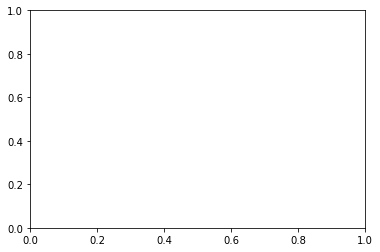

In [97]:
plt.plot( mycake.time, np.log10( test1['values'] ) )
#plt.gca().set_xlim((12.5, 12.7))
#plt.plot( test1['cost'][0:2,:] )

#test1['cost'][0:2,:]

In [38]:
cakespec = mycake.kspectrum( detrend = True)
cakespec2 = mycake.kspectrum(detrend = False);

At this point, I still have some doubts about how to calculate my spectra. It seems like calculating without detrending can help yield a more -5/3-like curve. Check veron and see if they detrend. Maybe there's no need to detrend since we're not doing segments? Also make sure that normalization is acting well. 

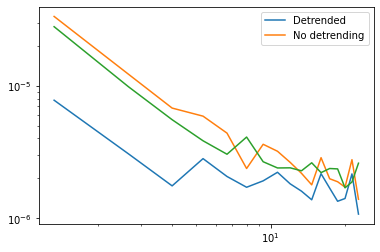

In [40]:
plt.loglog( aqdp['v1'].wvnum, cakespec[1081,:])
plt.loglog( aqdp['v1'].wvnum, cakespec2[1081,:])
plt.loglog( aqdp['v1'].wvnum, cakespec2[1085,:])
plt.legend(['Detrended','No detrending'])


In [7]:
fun = lambda x: 2*x**2; 
fun(np.linspace(3,5,3))

array([18., 32., 50.])